In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from utils import *
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, confusion_matrix

In [2]:
from IPython.display import display
pd.options.display.max_columns = None

# 1. Exploratory Data Analysis

In [3]:
customer_data = pd.read_csv('customer-data-20210628.csv')

In [4]:
customer_data.head()

,id,age,gender,race,driving_experience,education,income,credit_score,vehicle_ownership,vehicle_year,married,children,postal_code,annual_mileage,vehicle_type,speeding_violations,DUIs,past_accidents,outcome,telematic_score,monthly_mileage
0,569520,65+,female,majority,0-9y,high school,high,0.629027,True,after 2015,False,True,10238,12000.0,sedan,0,0,0,False,37.454012,1000.000000
1,750365,16-25,male,majority,0-9y,none,very low,0.357757,False,before 2015,False,False,10238,16000.0,sedan,0,0,0,True,95.071431,1333.333333
2,199901,16-25,female,majority,0-9y,high school,low,0.493146,True,before 2015,False,False,10238,11000.0,sedan,0,0,0,False,73.199394,916.666667
3,478866,16-25,male,majority,0-9y,university,low,0.206013,True,before 2015,False,True,32765,11000.0,sedan,0,0,0,False,59.865848,916.666667
4,731664,26-39,male,majority,10-19y,none,low,0.388366,True,before 2015,False,False,32765,12000.0,sedan,2,0,1,True,15.601864,1000.000000


In [5]:
customer_data.shape

(10000, 21)

In [6]:
customer_data.dtypes

id                       int64
age                     object
gender                  object
race                    object
driving_experience      object
education               object
income                  object
credit_score           float64
vehicle_ownership         bool
vehicle_year            object
married                   bool
children                  bool
postal_code              int64
annual_mileage         float64
vehicle_type            object
speeding_violations      int64
DUIs                     int64
past_accidents           int64
outcome                   bool
telematic_score        float64
monthly_mileage        float64
dtype: object

In [7]:
# postal_code contains categorical data
customer_data['postal_code'].unique()

array([10238, 32765, 92101, 21217])

In [8]:
customer_data.isnull().sum()

id                       0
age                      0
gender                   0
race                     0
driving_experience       0
education                0
income                   0
credit_score           982
vehicle_ownership        0
vehicle_year             0
married                  0
children                 0
postal_code              0
annual_mileage         957
vehicle_type             0
speeding_violations      0
DUIs                     0
past_accidents           0
outcome                  0
telematic_score          0
monthly_mileage        957
dtype: int64

In [9]:
customer_data.replace([np.inf, -np.inf], np.nan).isnull().sum()

id                       0
age                      0
gender                   0
race                     0
driving_experience       0
education                0
income                   0
credit_score           982
vehicle_ownership        0
vehicle_year             0
married                  0
children                 0
postal_code              0
annual_mileage         957
vehicle_type             0
speeding_violations      0
DUIs                     0
past_accidents           0
outcome                  0
telematic_score          0
monthly_mileage        957
dtype: int64

In [10]:
# annual_mileage and monthly_mileage are perfectly correlated, so I decided to drop annual mileage
(customer_data['annual_mileage'] / customer_data['monthly_mileage']).value_counts()

12.0    9043
dtype: int64

In [11]:
# drop id and annual_mileage since they are not useful columns
customer_data.drop(['id', 'annual_mileage'], axis=1, inplace=True)

In [12]:
# 18.51% of data points that have missing values for at least one the features 
customer_data.isnull().sum(axis=1).to_frame('nans').all(1).mean()

0.1851

In [13]:
customer_data.describe()

,credit_score,postal_code,speeding_violations,DUIs,past_accidents,telematic_score,monthly_mileage
count,9018.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,9043.000000
mean,0.515813,19864.548400,1.482900,0.23920,1.056300,49.415956,974.750267
std,0.137688,18915.613855,2.241966,0.55499,1.652454,28.763013,234.869544
min,0.053358,10238.000000,0.000000,0.00000,0.000000,0.001163,166.666667
25%,0.417191,10238.000000,0.000000,0.00000,0.000000,24.632887,833.333333
50%,0.525033,10238.000000,0.000000,0.00000,0.000000,49.252862,1000.000000
75%,0.618312,32765.000000,2.000000,0.00000,2.000000,74.000635,1166.666667
max,0.960819,92101.000000,22.000000,6.00000,15.000000,99.971767,1833.333333


There are  10000 data points and 21 columns
- `id` is not a useful column
- 13 columns contain categorical data: including the target column `outcome` (which is bool) and `postal_code`
- 7 columns contain numerical data
- `annual_mileage` = 12*`monthly_mileage`: one of them can be dropped since they are perfectly correlated.
- `credit_score` and `monthly_mileage` have missing values: respectively 9.82% and 9.57% of the data points.
- 18.51% of the data points have missing values for at least one of the features
- Some numerical data don't have a lot of variance, e.g. DUIs values are 0 in more than 75% of the cases

## Check missing values

#### `credit_score`

<AxesSubplot:xlabel='outcome', ylabel='credit_score'>

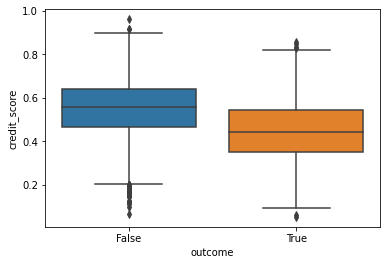

In [14]:
sns.boxplot(x='outcome', y='credit_score', data=customer_data)

The box plot above shows the distribution of `credit_score` which seems to be different for different `outcome` values, suggesting that this column contains information regarding the target. Customers that have not made claims tend to have a higher credit score than customer that have made a claim. It is important missing values in `credit_score` to be handled well.

<AxesSubplot:xlabel='credit_score', ylabel='Count'>

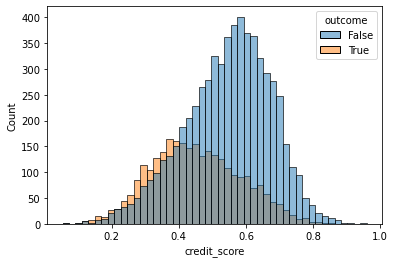

In [15]:
# histogram of credit_score for different outcome values which again confirms what was stated above
sns.histplot(data=customer_data, x='credit_score', hue='outcome')

In [16]:
# Try to fill missing values with mean value for credit_score
credit_score_mean = customer_data['credit_score'].mean()
customer_data['credit_score_mean'] = customer_data['credit_score'].copy()
customer_data['credit_score_mean'].fillna(credit_score_mean, inplace=True)

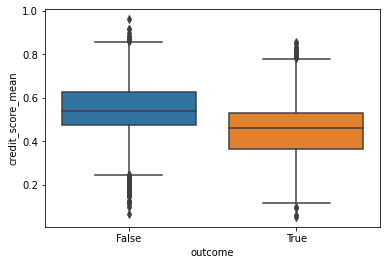

<AxesSubplot:xlabel='credit_score_mean', ylabel='Count'>

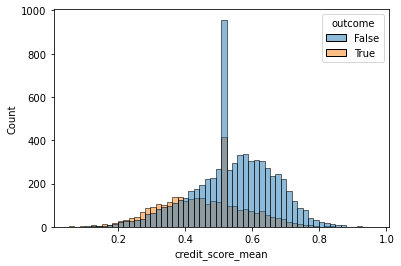

In [17]:
sns.boxplot(x='outcome', y='credit_score_mean', data=customer_data)
plt.show()
sns.histplot(data=customer_data, x='credit_score_mean', hue='outcome')

The distribution of credit_score does not look nice after fillinf missing values with the mean.

#### `monthly_mileage`

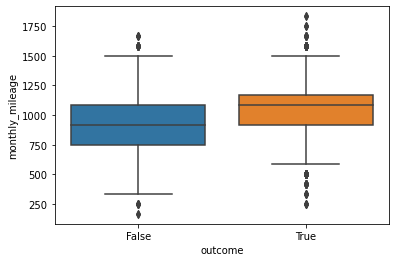

<AxesSubplot:xlabel='monthly_mileage', ylabel='Count'>

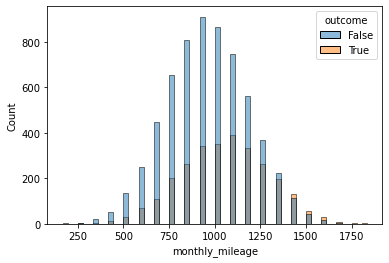

In [18]:
sns.boxplot(x='outcome', y='monthly_mileage', data=customer_data)
plt.show()
sns.histplot(data=customer_data, x='monthly_mileage', hue='outcome', bins=60)

Distribution of the `monthly_mileage` seems to be different for different `outcome` values, suggesting that this column contains information regarding the target. Customers that have not made claims tend to have lower monthly mileage than customers that have made claims.

In [19]:
# fill missing values with the mean value
monthly_mileage_mean = customer_data['monthly_mileage'].mean()
customer_data['monthly_mileage_mean'] = customer_data['monthly_mileage'].copy()
customer_data['monthly_mileage_mean'].fillna(monthly_mileage_mean, inplace=True)

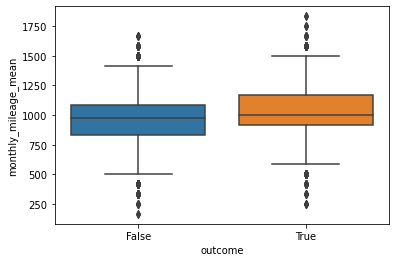

<AxesSubplot:xlabel='monthly_mileage_mean', ylabel='Count'>

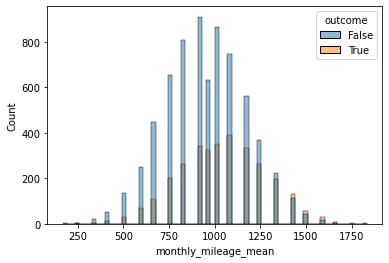

In [20]:
sns.boxplot(x='outcome', y='monthly_mileage_mean', data=customer_data)
plt.show()
sns.histplot(data=customer_data, x='monthly_mileage_mean', hue='outcome')

Filling missing values with the mean changes the skewness of the distribution of `monthly_mileage`.

Next I will try to use fill missing values for both columns using the information from the categorical columns. Firstly I check of the missing values in the columns are somehow correlated to any of the categorical features or target. E.g. the missing values in `credit_score` might mean that the customer didn't have a credit score, because for example the customer was very young. Missing values in `monthly_mileage` might be related to the customer not owning a car.

In [21]:
# get a list of categorical columns
categorical_columns = list(customer_data.select_dtypes(include=['bool', 'object']).columns)
categorical_columns.append('postal_code')
categorical_columns

['age',
 'gender',
 'race',
 'driving_experience',
 'education',
 'income',
 'vehicle_ownership',
 'vehicle_year',
 'married',
 'children',
 'vehicle_type',
 'outcome',
 'postal_code']

#### Check if there is a pattern in missing values for different categories - CREDIT SCORE

/var/folders/wb/f61s898j12x1z8q8hx6jpg4h0000gn/T/ipykernel_22538/1356870228.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/wb/f61s898j12x1z8q8hx6jpg4h0000gn/T/ipykernel_22538/1356870228.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/wb/f61s898j12x1z8q8hx6jpg4h0000gn/T/ipykernel_22538/1356870228.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/wb/f61s898j12x1z8q8hx6jpg4h0000gn/T/ipykernel_22538/1356870228.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/wb/f61s898j12x1z8q8hx6jpg4h0000gn/T/ipy

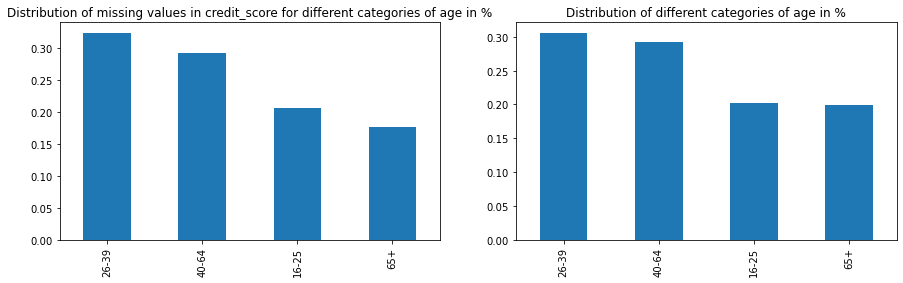

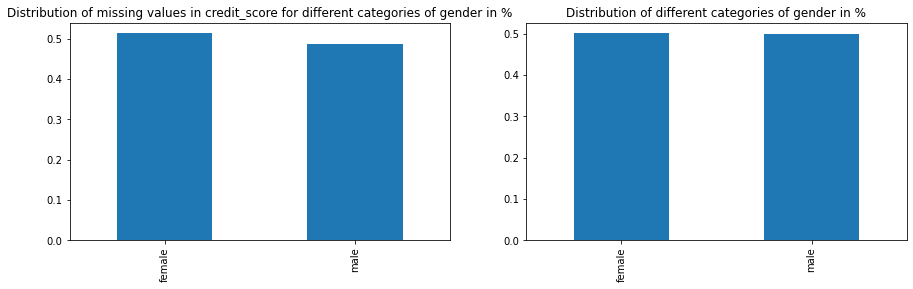

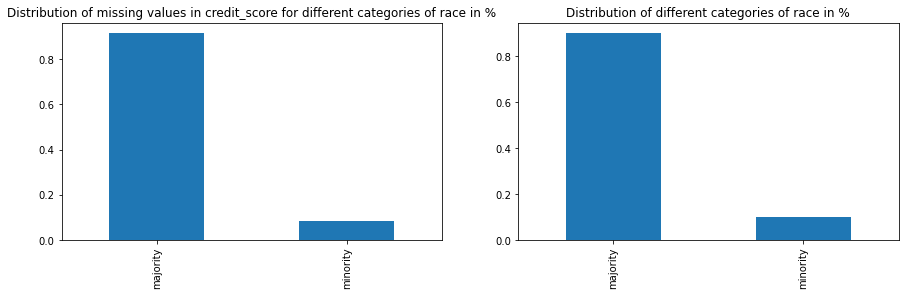

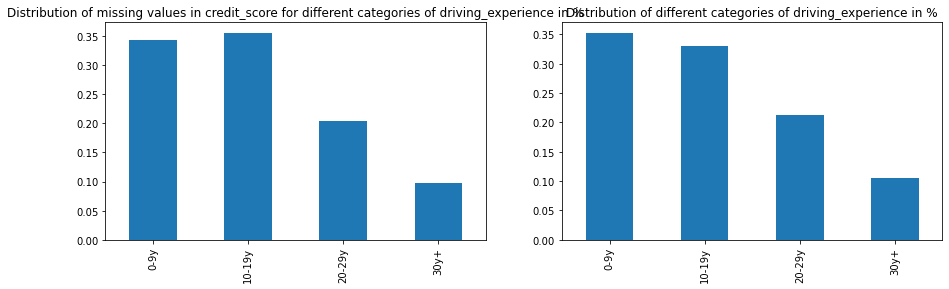

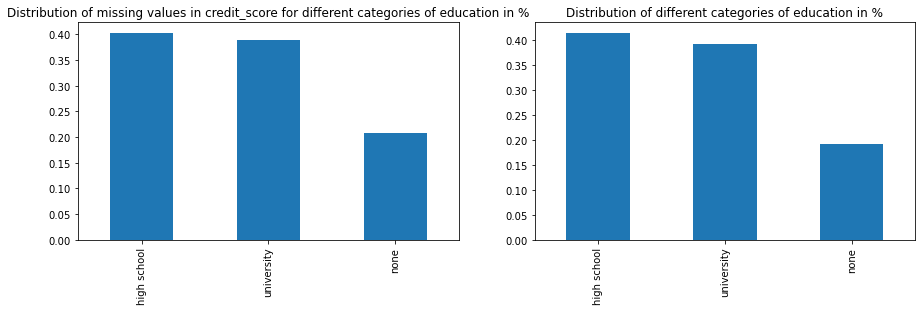

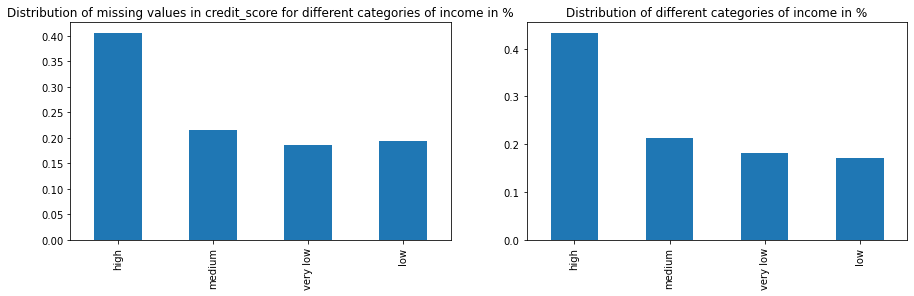

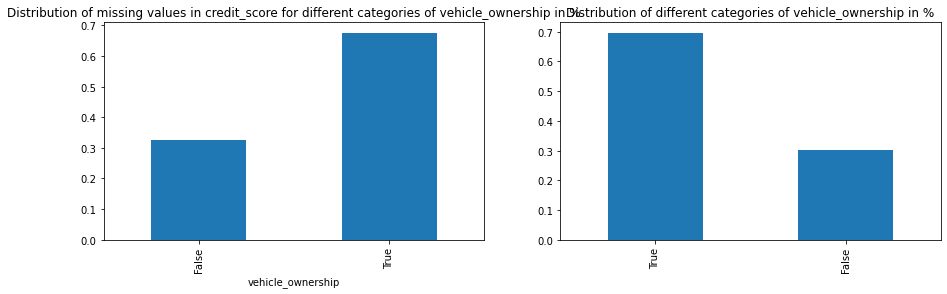

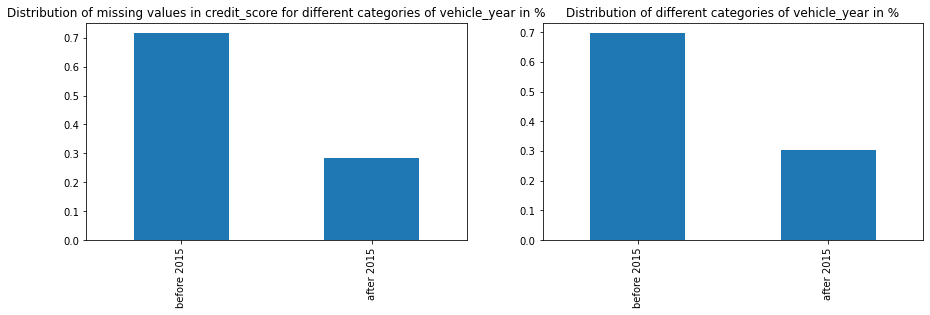

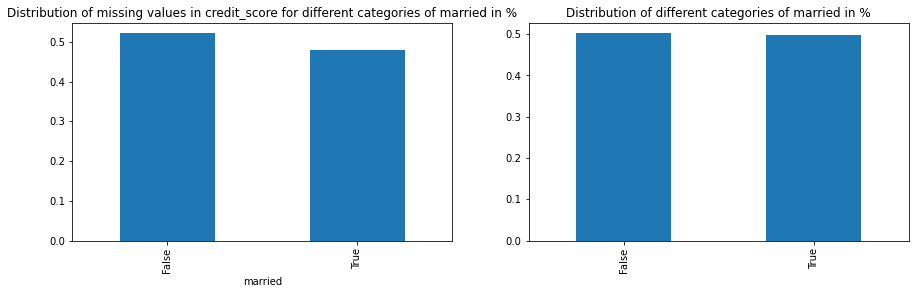

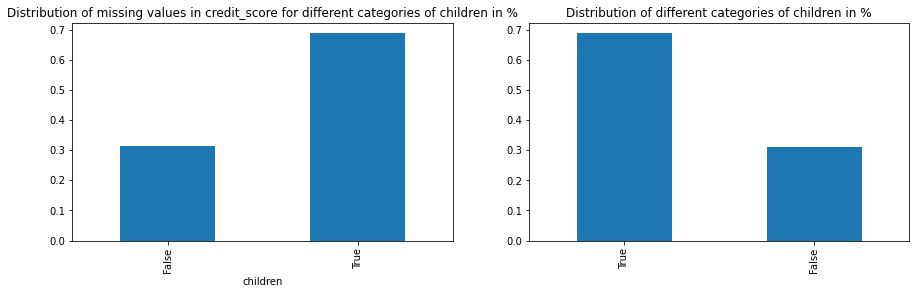

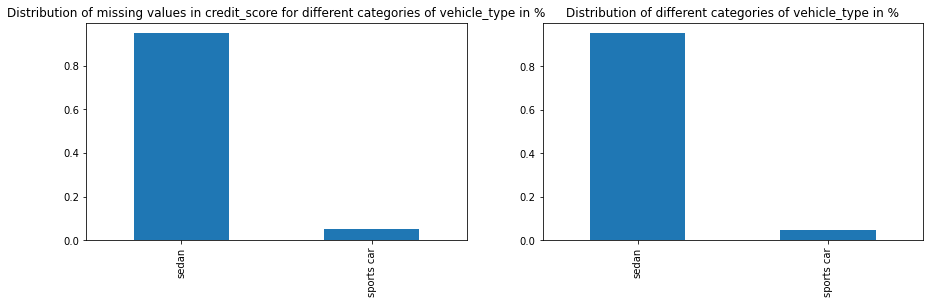

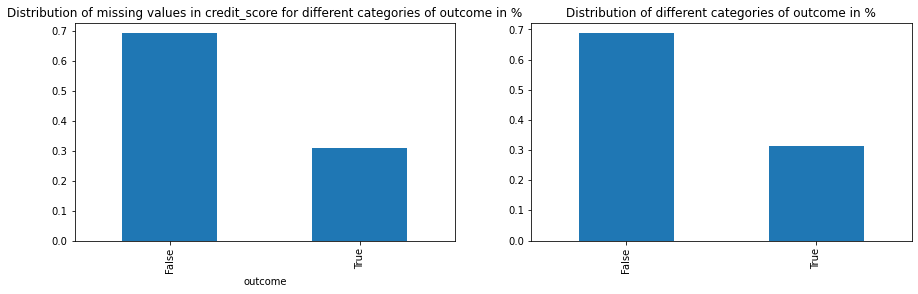

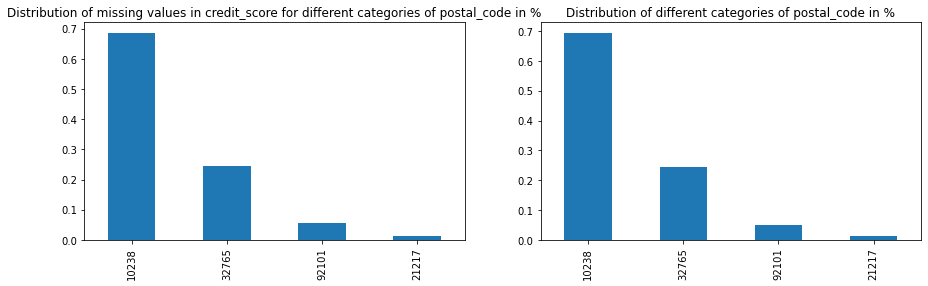

In [22]:
cs_nulls = customer_data.isnull().sum()['credit_score']
for c in categorical_columns: 
    fig, ax = plt.subplots(1,2, figsize=(15,4))
    categories_counts = customer_data[c].value_counts()
    (categories_counts/categories_counts.sum()).plot.bar(ax=ax[1])
    if False in categories_counts.index and True in categories_counts.index: 
        customer_data.groupby(c).apply(lambda x: x['credit_score'].isnull().sum()/cs_nulls).plot.bar(ax=ax[0])
    else:
        customer_data.groupby(c).apply(lambda x: x['credit_score'].isnull().sum()/cs_nulls).loc[categories_counts.index].plot.bar(ax=ax[0])
    ax[0].set_title(f'Distribution of missing values in credit_score for different categories of {c} in %')
    ax[1].set_title(f'Distribution of different categories of {c} in %')
    fig.show()

It seems that there is no pattern in missing values in credit score with respect to the categorical data. The distribution of missing values among different categories follows the total distribution of the data among the categories. 

Next, I decided to plot the distribution of `credit_score` for different categories of each categorical data to see if it differs. The purpose is to identify the categorical columns for which `credit_score` has different distribution among the categories, group the data using those categorical columns and fill missing values in `credit_score` with the mean of the group. There are many categorical features: if we would use all of them to group the data we would have too many groups in total, and many of them would have only 1 data point (the mean of 1 data point is not a reliable estimation of the mean)

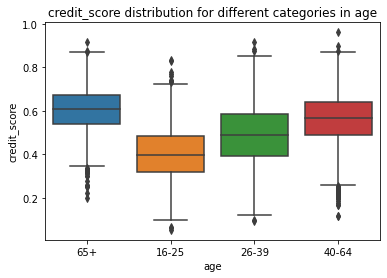

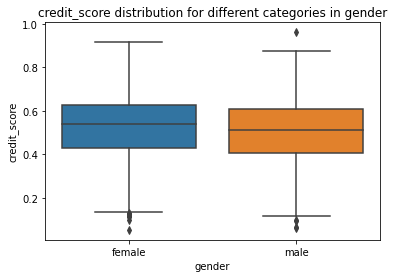

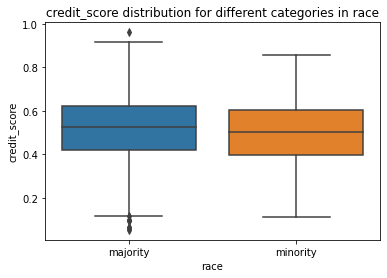

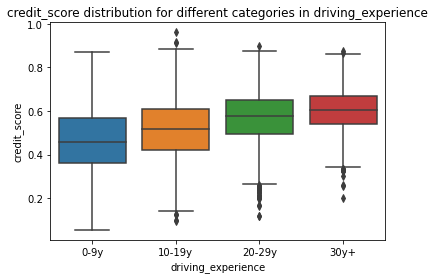

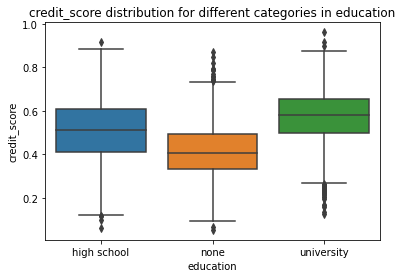

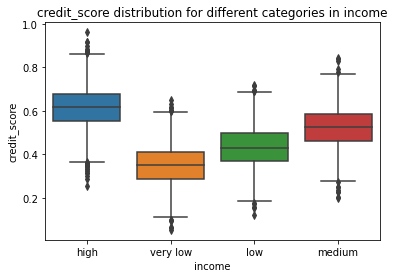

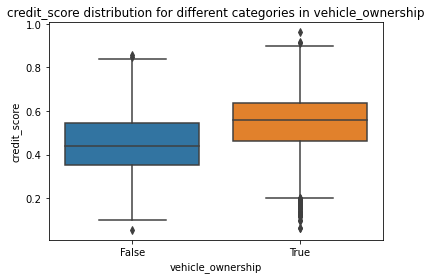

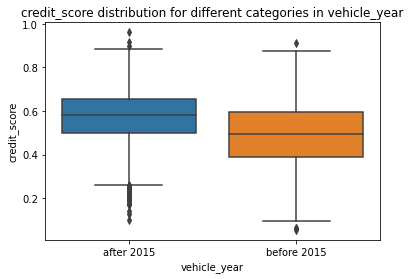

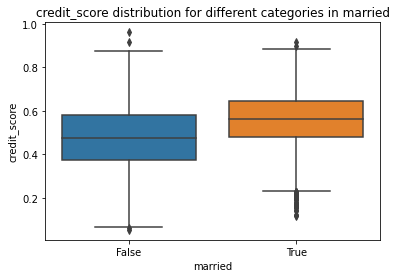

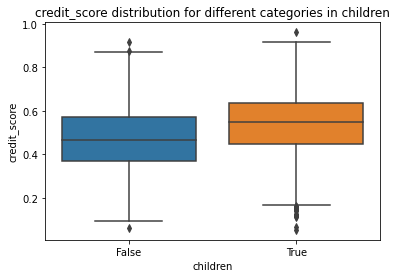

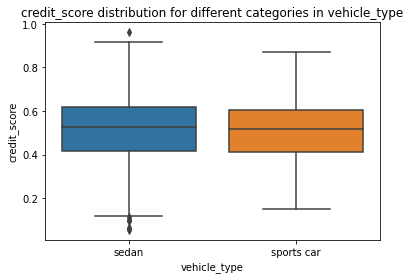

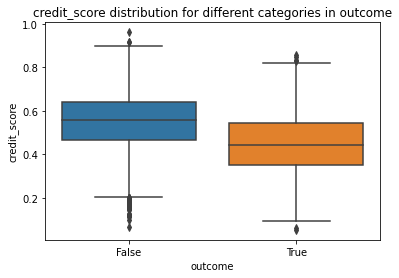

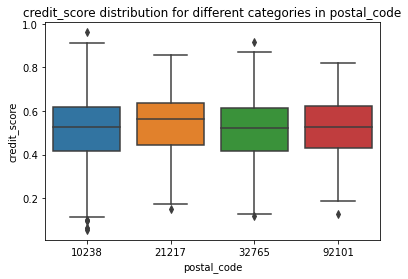

In [23]:
# Check the distribution of credit_score for different categories
for c in categorical_columns:
    sns.boxplot(x=c, y='credit_score', data=customer_data)
    plt.title(f'credit_score distribution for different categories in {c}')
    plt.show()

For some categorical columns it seems that the distribution of credit_score is different for different categories, suggesting that we should use categories into account when handling missing values. The following categorical columns were chosen:  
- age, income, driving experience, income: credit_score seems to have different distribution for different categories in these categorical columns. However to avoid a large number of groups, I decided to use only `age` since age, income, driving experience and education seem to be correlated (from the bar plots below: older age groups tend to have higher income, more driving experience, and higher education)
- vehicle_ownership
- vehicle_year
- married

For the other categorical columns, the distribution of credit_score is not very different for different categories, so I decided not to use them for missing values purposes.

<AxesSubplot:xlabel='0', ylabel='age'>

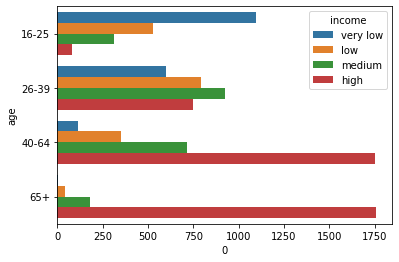

In [24]:
sns.barplot(data=customer_data.groupby(['age', 'income']).size().reset_index(), x=0, y='age', hue='income',
           hue_order=['very low', 'low', 'medium', 'high']
           )

<AxesSubplot:xlabel='0', ylabel='age'>

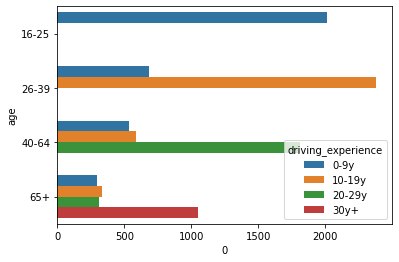

In [25]:
sns.barplot(data=customer_data.groupby(['age', 'driving_experience']).size().reset_index(), x=0, y='age', hue='driving_experience',
           hue_order=['0-9y', '10-19y', '20-29y', '30y+']
           )

<AxesSubplot:xlabel='0', ylabel='age'>

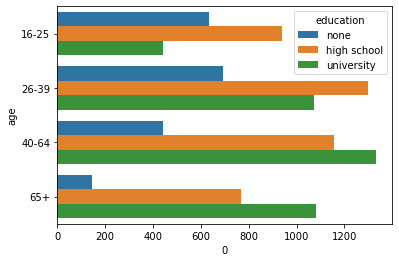

In [26]:
sns.barplot(data=customer_data.groupby(['age', 'education']).size().reset_index(), x=0, y='age', hue='education',
           hue_order=['none', 'high school', 'university']
           )

In [27]:
categorical_columns_CS = [
 'age',
 'vehicle_ownership',
 'vehicle_year',
 'married'
]

In [28]:
# 32 different groups
customer_data.groupby(categorical_columns_CS).size().shape

(32,)

In [29]:
# each group has at least 20 data points, with 50% of the groups have between 102 and 590 data points
customer_data.groupby(categorical_columns_CS).size().describe()

count     32.000000
mean     312.500000
std      261.037755
min       20.000000
25%      102.500000
50%      212.500000
75%      590.500000
max      850.000000
dtype: float64

In [30]:
# fill missing values using the mean creadit_score of each group
customer_data['credit_score_original'] = customer_data['credit_score'].copy()
customer_data['credit_score'] = customer_data.groupby(categorical_columns_CS).apply(
    lambda x: x['credit_score'].fillna(x['credit_score'].mean())).reset_index().set_index('level_4').sort_index()['credit_score']

In [31]:
customer_data['credit_score'].isnull().sum()

0

In [32]:
customer_data[['credit_score_original', 'credit_score']].isnull().sum()

credit_score_original    982
credit_score               0
dtype: int64

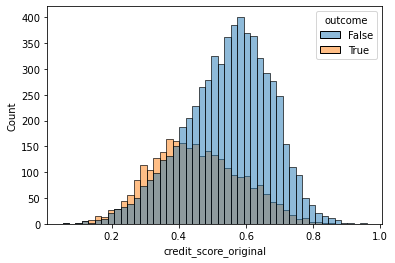

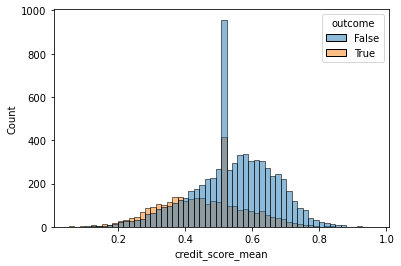

<AxesSubplot:xlabel='credit_score', ylabel='Count'>

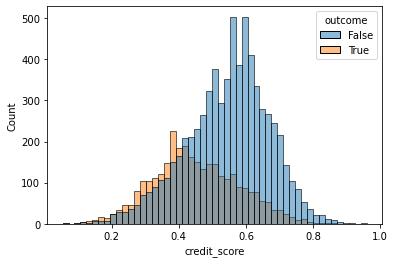

In [33]:
# filling missing values using different groups seems to be better compared to using the mean of all the data
sns.histplot(data=customer_data, x='credit_score_original', hue='outcome')
plt.show()
sns.histplot(data=customer_data, x='credit_score_mean', hue='outcome')
plt.show()
sns.histplot(data=customer_data, x='credit_score', hue='outcome')

#### Check if there is a pattern in missing values for different categories - MONTHLY MILEAGE

/var/folders/wb/f61s898j12x1z8q8hx6jpg4h0000gn/T/ipykernel_22538/4168519844.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/wb/f61s898j12x1z8q8hx6jpg4h0000gn/T/ipykernel_22538/4168519844.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/wb/f61s898j12x1z8q8hx6jpg4h0000gn/T/ipykernel_22538/4168519844.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/wb/f61s898j12x1z8q8hx6jpg4h0000gn/T/ipykernel_22538/4168519844.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/wb/f61s898j12x1z8q8hx6jpg4h0000gn/T/ipy

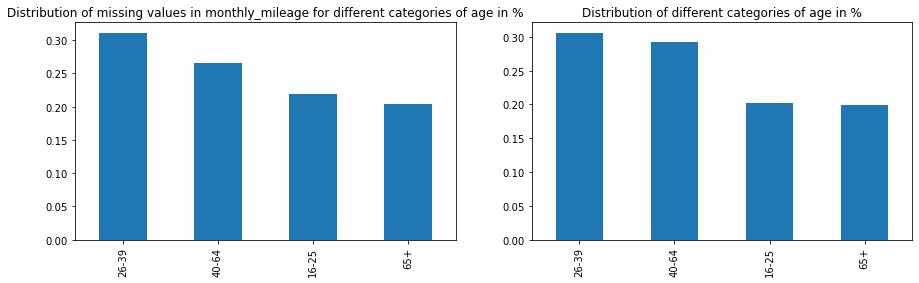

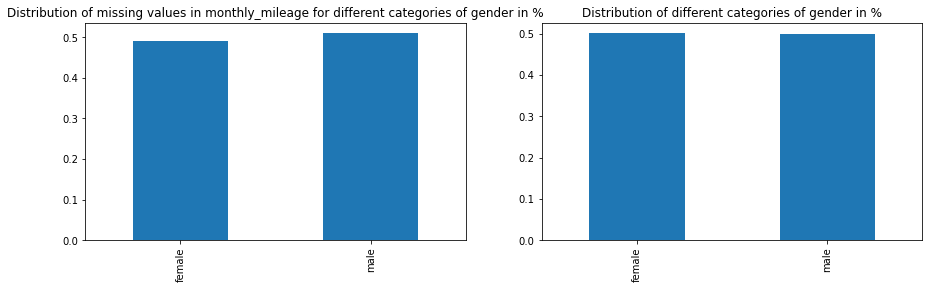

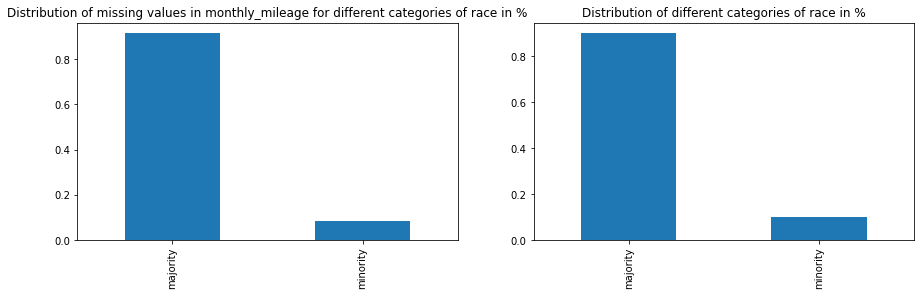

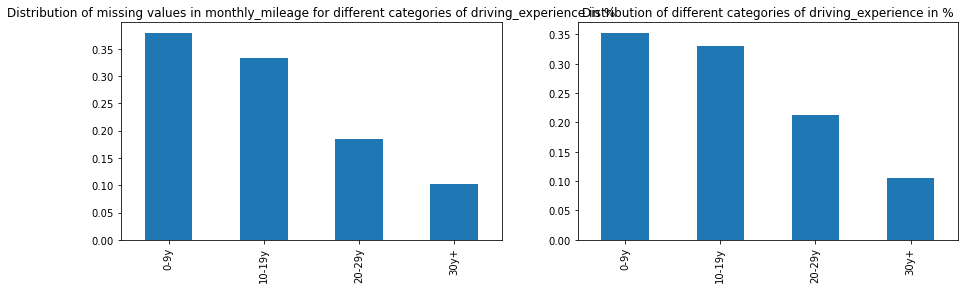

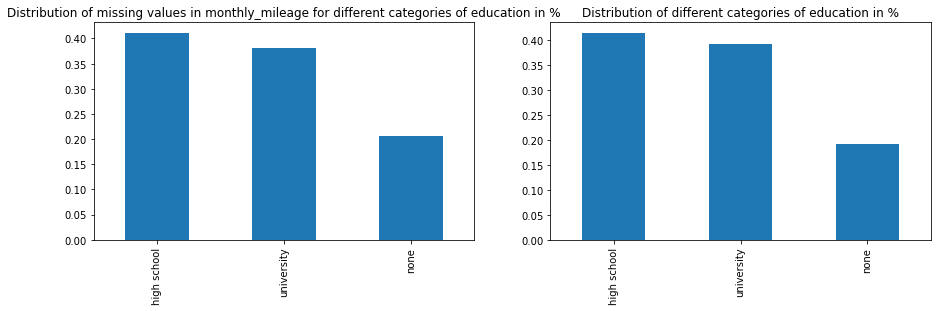

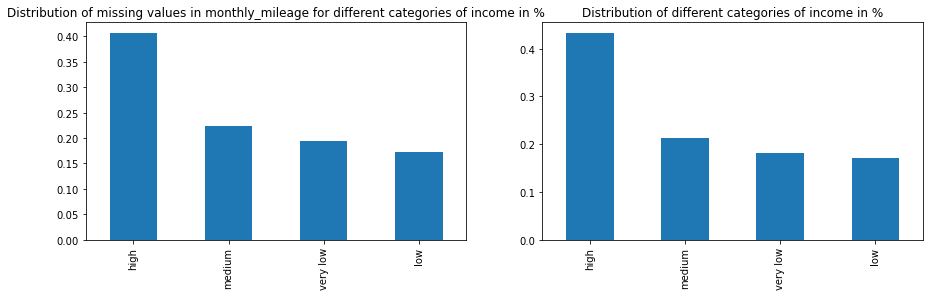

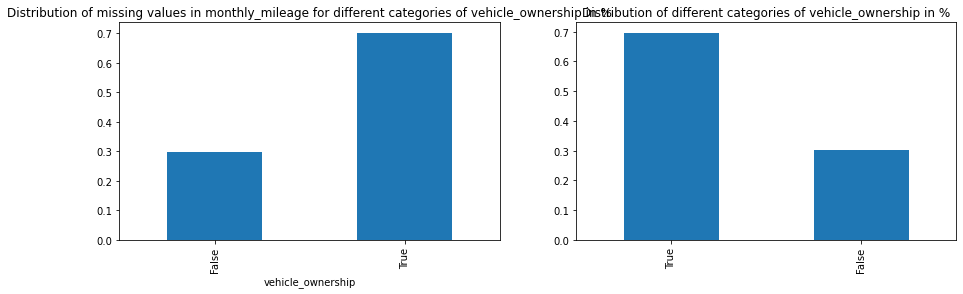

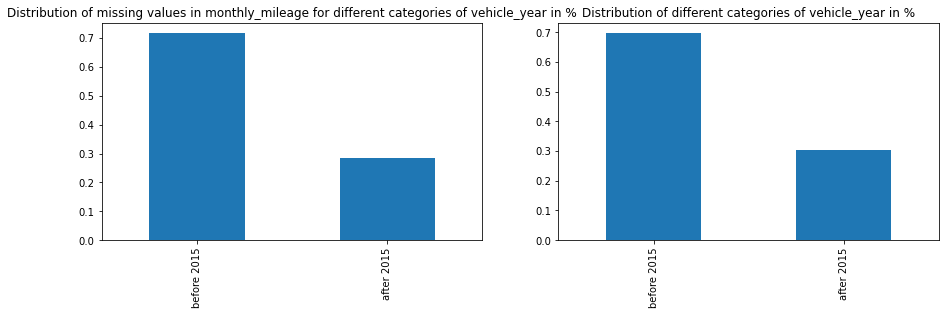

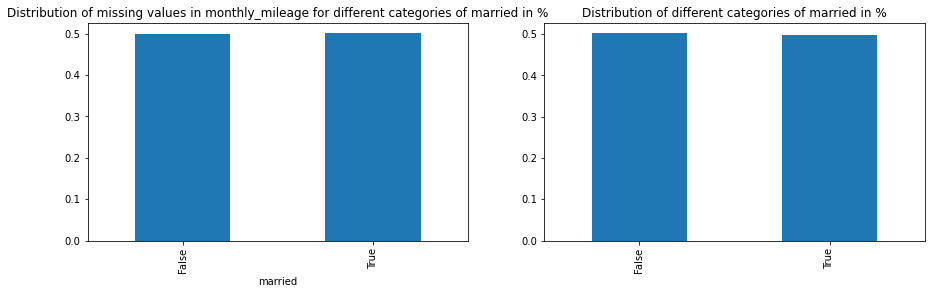

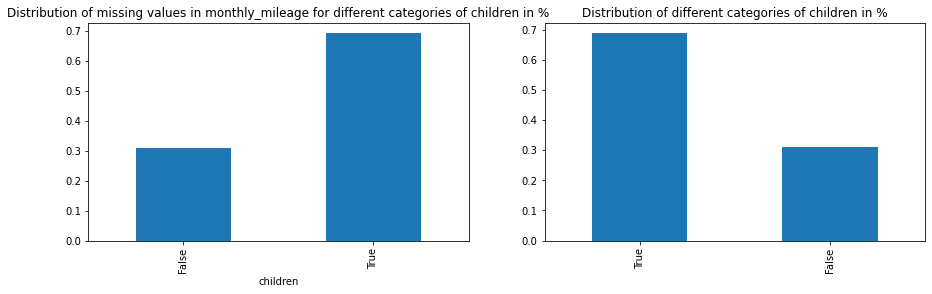

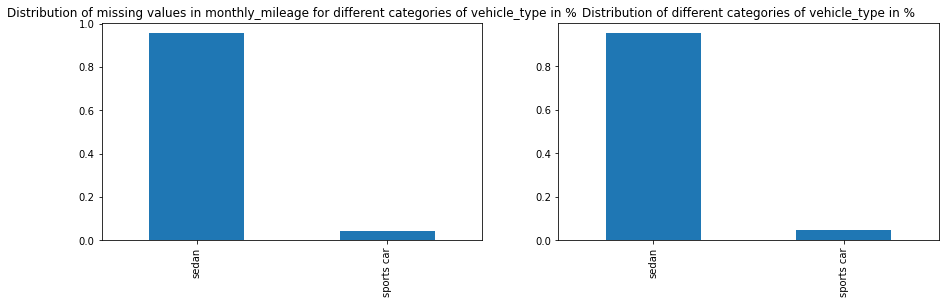

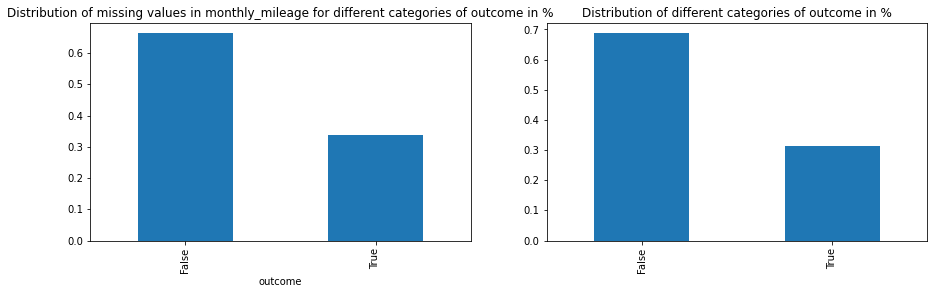

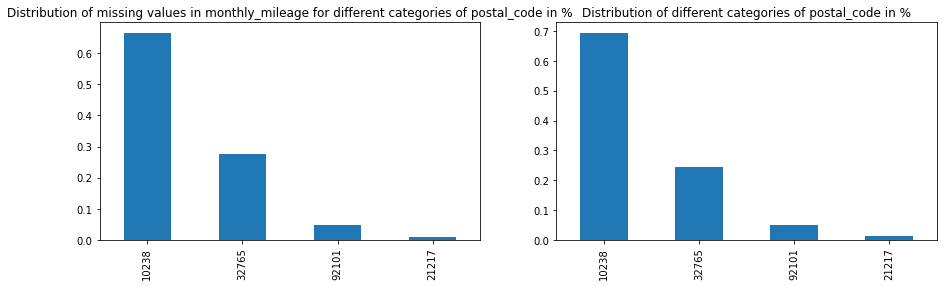

In [34]:
mm_nulls = customer_data.isnull().sum()['monthly_mileage']
for c in categorical_columns:
    fig, ax = plt.subplots(1,2, figsize=(15,4))
    categories_counts = customer_data[c].value_counts()
    (categories_counts / categories_counts.sum()).plot.bar(ax=ax[1])
    if False in categories_counts.index and True in categories_counts.index: 
        customer_data.groupby(c).apply(lambda x: x['monthly_mileage'].isnull().sum()/ mm_nulls).plot.bar(ax=ax[0])
    else:
        customer_data.groupby(c).apply(lambda x: x['monthly_mileage'].isnull().sum()/mm_nulls).loc[categories_counts.index].plot.bar(ax=ax[0])
    ax[0].set_title(f'Distribution of missing values in monthly_mileage for different categories of {c} in %')
    ax[1].set_title(f'Distribution of different categories of {c} in %')
    
    fig.show()

It seems that there is no pattern in missing values in monthly mileage with respect to the categorical data. The distribution of missing values among different categories follows the total distribution of the data among the categories. 

I proceded to fill missing values in monthly mileage in a similar fashion as I did for credit score.

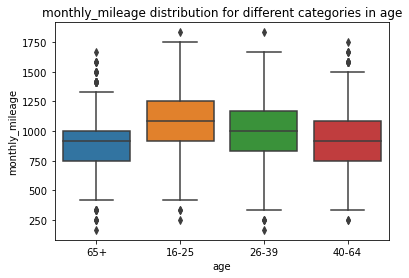

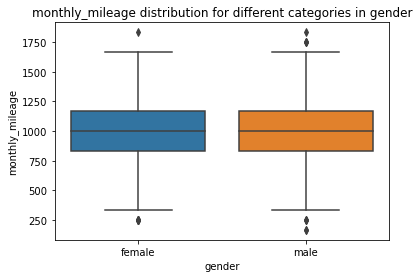

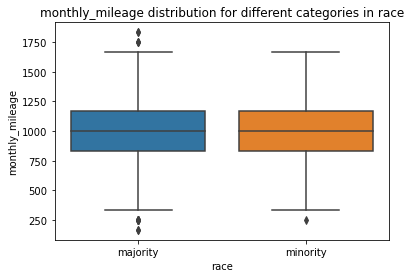

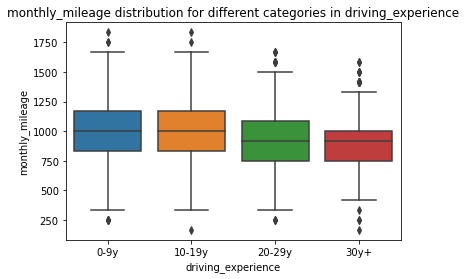

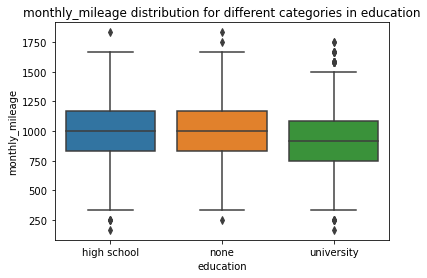

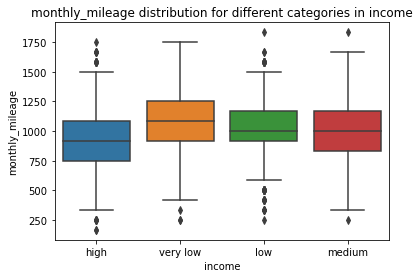

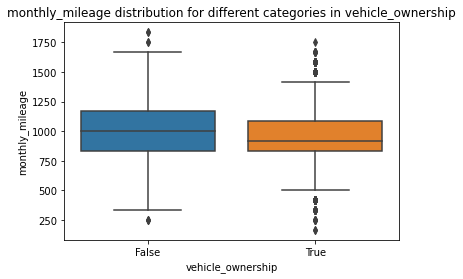

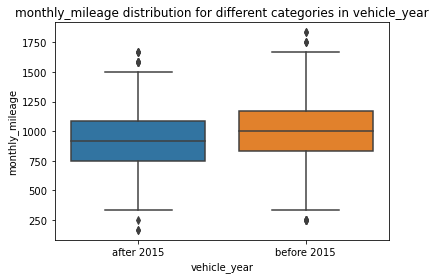

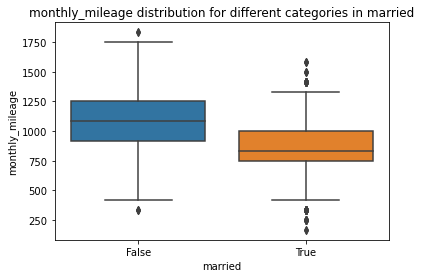

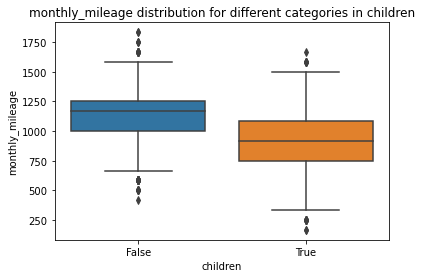

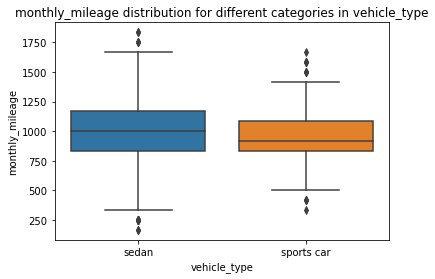

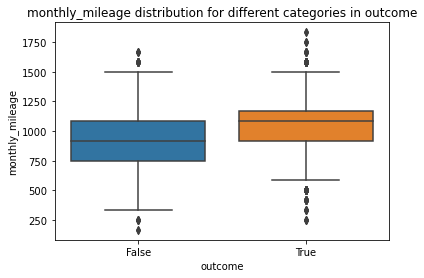

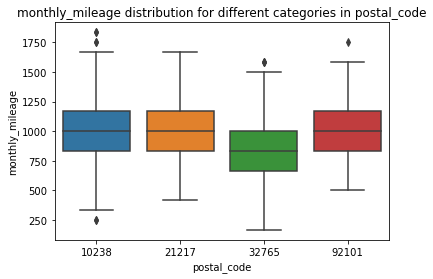

In [35]:
# Check the distribution of monthly_mileage for different categories
for c in categorical_columns:
    sns.boxplot(x=c, y='monthly_mileage', data=customer_data)
    plt.title(f'monthly_mileage distribution for different categories in {c}')
    plt.show()

I decided to use the following categorical columns into account when handling missing values. 
- age (for the same reason explained in the credit score section i did not use driving experience, education and income)
- married
- children
- postal_code: regroup into 2 categories: 32765 or other

In [36]:
categorical_columns_MM = [
 'age',
 'married',
 'children',
 'postal_code_MM']

In [37]:
types_of_postal_code = {f: 'other' if f != 32765 else f for f in customer_data['postal_code'].unique()}
print(types_of_postal_code)
customer_data['postal_code_MM'] = customer_data['postal_code'].map(types_of_postal_code)
customer_data['postal_code_MM'].unique()

{10238: 'other', 32765: 32765, 92101: 'other', 21217: 'other'}


array(['other', 32765], dtype=object)

In [38]:
# 32 different groups: 50% of the groups have between 83 and 391 data points
customer_data.groupby(categorical_columns_MM).size().describe()

count      32.000000
mean      312.500000
std       302.430264
min        16.000000
25%        83.250000
50%       226.000000
75%       391.250000
max      1159.000000
dtype: float64

In [39]:
customer_data['monthly_mileage_original'] = customer_data['monthly_mileage'].copy()

In [40]:
customer_data['monthly_mileage'] = customer_data.groupby(categorical_columns_MM).apply(
    lambda x: x['monthly_mileage'].fillna(x['monthly_mileage'].mean())).reset_index().set_index('level_4').sort_index()['monthly_mileage']

In [41]:
customer_data[['monthly_mileage_original', 'monthly_mileage']].isnull().sum()

monthly_mileage_original    957
monthly_mileage               0
dtype: int64

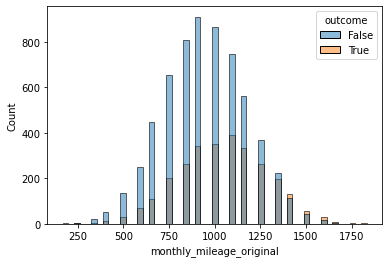

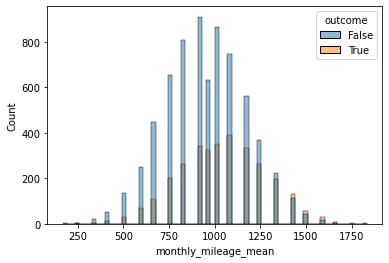

<AxesSubplot:xlabel='monthly_mileage', ylabel='Count'>

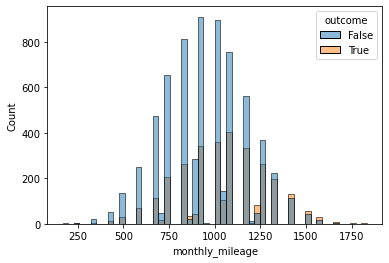

In [42]:
sns.histplot(data=customer_data, x='monthly_mileage_original', hue='outcome')
plt.show()
sns.histplot(data=customer_data, x='monthly_mileage_mean', hue='outcome')
plt.show()
sns.histplot(data=customer_data, x='monthly_mileage', hue='outcome')

## Question 1.1

What proportion of customers with a credit score below 0.2 made a claim in the last year?
Around 60.2% of customers with a credit score below 0.2 made a claim in the last year.

In [43]:
len(customer_data.query('credit_score < 0.2 and outcome == True')) / len(customer_data.query('credit_score < 0.2'))

0.6020408163265306

## Question 1.2

Produce a maximum of 3 plots to help the client understand their data better. Explain what the plots show/any insight they provide the client about their data.

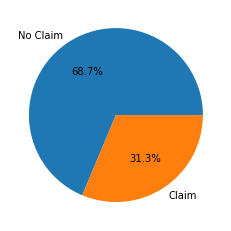

In [44]:
fig, ax = plt.subplots()
df = 100*customer_data['outcome'].value_counts()/ len(customer_data)
_ = plt.pie(data=df.to_frame(), x='outcome', autopct='%.1f%%', labels = ['No Claim', 'Claim'])

The pie plot above shows the percentage of customers that made a claim vs percentage of customers that did not make a claim last year. The clients data is imbalanced: 68.7% of the customers have not made a claim in the past year, while 31.3% of them have made a claim.

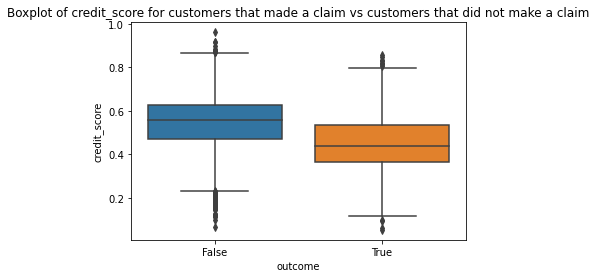

In [45]:
_ = sns.boxplot(x='outcome', y='credit_score', data=customer_data)
_ = plt.title('Boxplot of credit_score for customers that made a claim vs customers that did not make a claim')

The boxplot above shows the distribution of credit score for customers that made a claim and customers that did not make a claim last year. Customers that did not make a claim tend to have higher credit score compared to customers that did not make a claim.

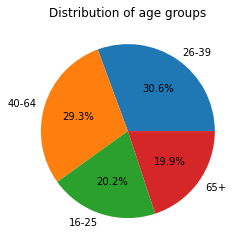

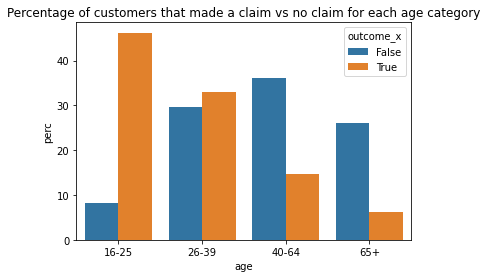

In [46]:
categories_counts = customer_data.groupby(['age', 'outcome']).size().to_frame('counts').reset_index()

categories_counts = categories_counts.merge(customer_data['outcome'].value_counts().reset_index(), left_on='outcome', 
                        right_on='index', how='outer')
categories_counts['perc'] = 100*categories_counts['counts'] / categories_counts['outcome_y']

fig, ax = plt.subplots()
df = customer_data['age'].value_counts() / customer_data.shape[0]
_ = plt.pie(data=df.to_frame(), x='age', autopct='%.1f%%', labels=df.index)
_ = plt.title('Distribution of age groups')
plt.show()

sns.barplot(x='age', y='perc', data=categories_counts, hue='outcome_x')
plt.title('Percentage of customers that made a claim vs no claim for each age category')
plt.show()

In [47]:
df

26-39    0.3063
40-64    0.2931
16-25    0.2016
65+      0.1990
Name: age, dtype: float64

The pie plot shows the distribution of age categories: there are 4 age groups starting from 16y. 60% of the customers are between 26-64 years old. 
The bar plot shows how the number of total claims is distributed across the age groups in percentages (orange bars sum to 100% and blue bars sum to 100%). It seems that younger customers tend to make more claims compared to older customers. The 16-25 age group is responsible for more than 45% of total number of claims even though only 20% of customers belong to this age group.

# 2. Modelling

## 2.1 Data preprocessing

The categorical data will be encoded.

In [48]:
categorical_columns

['age',
 'gender',
 'race',
 'driving_experience',
 'education',
 'income',
 'vehicle_ownership',
 'vehicle_year',
 'married',
 'children',
 'vehicle_type',
 'outcome',
 'postal_code']

Check for each categorical variable the numer of categories and number of data points for each category

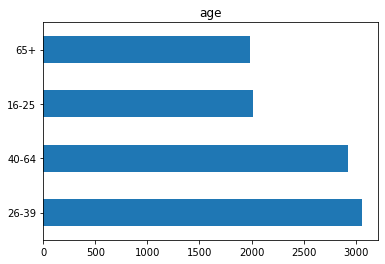

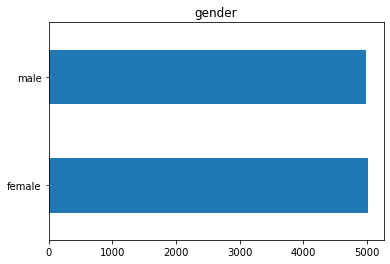

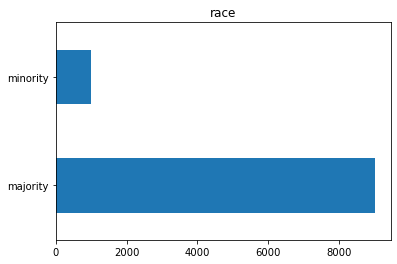

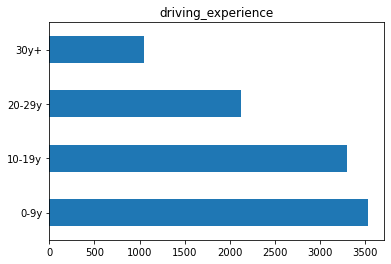

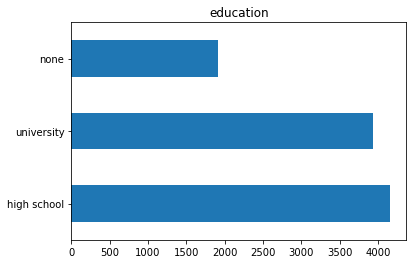

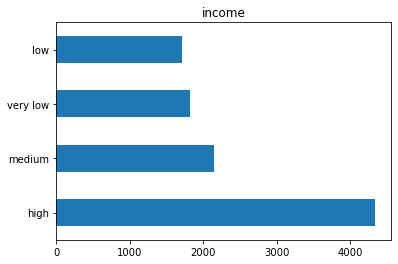

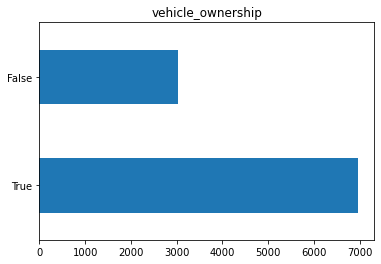

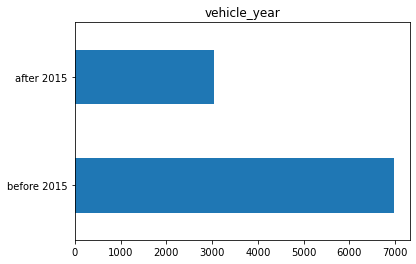

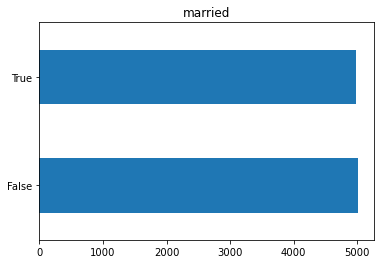

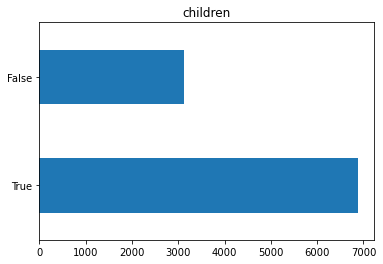

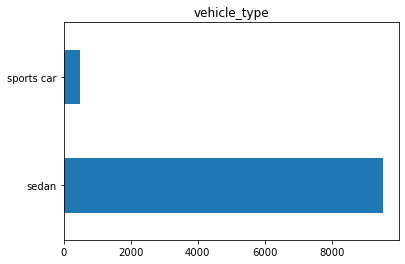

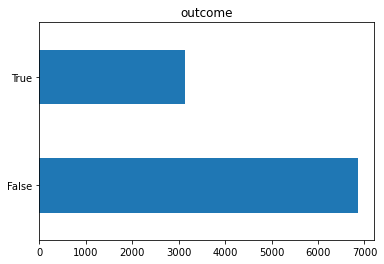

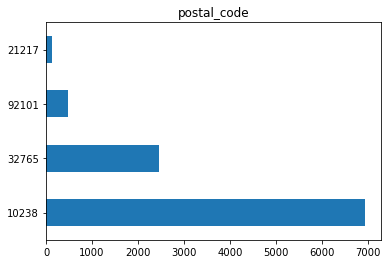

In [49]:
for c in categorical_columns:
    customer_data[c].value_counts().plot.barh()
    plt.title(c)
    plt.show()

#### Ordinal variables
- `age` has 4 different categories and it is an ordinal variable. 
- `driving_experience` has 4 categories and it is an ordinal variable. 
- `education` has 3 categories and it is an ordinal variable 
- `income` has 4 categories and it is an ordinal variable 

For these variables the order of categories matter and I encode them using OrdinalEncoder

In [50]:
customer_data['age'].unique()

array(['65+', '16-25', '26-39', '40-64'], dtype=object)

In [51]:
ordinal_map = [['16-25', '26-39', '40-64', '65+']]
customer_data = ordinal_encode(customer_data, 'age', ordinal_map)

In [52]:
customer_data['driving_experience'].unique()

array(['0-9y', '10-19y', '20-29y', '30y+'], dtype=object)

In [53]:
ordinal_map = [['0-9y', '10-19y', '20-29y', '30y+']]
customer_data = ordinal_encode(customer_data, 'driving_experience', ordinal_map)

In [54]:
customer_data['education'].unique()

array(['high school', 'none', 'university'], dtype=object)

In [55]:
ordinal_map = [['none', 'high school', 'university']]
customer_data = ordinal_encode(customer_data, 'education', ordinal_map)

In [56]:
customer_data['income'].unique()

array(['high', 'very low', 'low', 'medium'], dtype=object)

In [57]:
ordinal_map = [['very low', 'low', 'medium', 'high']]
customer_data = ordinal_encode(customer_data, 'income', ordinal_map)

In [58]:
customer_data.columns

Index(['age', 'gender', 'race', 'driving_experience', 'education', 'income',
       'credit_score', 'vehicle_ownership', 'vehicle_year', 'married',
       'children', 'postal_code', 'vehicle_type', 'speeding_violations',
       'DUIs', 'past_accidents', 'outcome', 'telematic_score',
       'monthly_mileage', 'credit_score_mean', 'monthly_mileage_mean',
       'credit_score_original', 'postal_code_MM', 'monthly_mileage_original',
       'age_ordinal', 'driving_experience_ordinal', 'education_ordinal',
       'income_ordinal'],
      dtype='object')

#### Nominal variables
- `gender`
- `race`
- `vehicle_ownership`
- `vehicle_year`
- `married`
- `children`
- `vehicle_type`
- `postal_code`

These are nominal variables with 2 categories (apart from `postal_code` which has 4). They will be one-hot encoded.

In [59]:
customer_data = one_hot_encode(customer_data, 'gender')
customer_data = one_hot_encode(customer_data, 'race')
customer_data = one_hot_encode(customer_data, 'vehicle_ownership')
customer_data = one_hot_encode(customer_data, 'vehicle_year')
# customer_data = one_hot_encode(customer_data, 'married')
# customer_data = one_hot_encode(customer_data, 'children')
customer_data = one_hot_encode(customer_data, 'vehicle_type')

In [60]:
customer_data['postal_code'].value_counts()

10238    6940
32765    2456
92101     484
21217     120
Name: postal_code, dtype: int64

There are not a lot of data for the last postal code, so I will group the 2 least frequent postal codes into a new category `others`.

In [61]:
types_of_postal_code = {f: 'other' if f in [21217, 92101] else str(f) for f in customer_data['postal_code'].unique()}
print(types_of_postal_code)
customer_data['postal_code_modelling'] = customer_data['postal_code'].map(types_of_postal_code)
customer_data['postal_code_modelling'].unique()

{10238: '10238', 32765: '32765', 92101: 'other', 21217: 'other'}


array(['10238', '32765', 'other'], dtype=object)

In [62]:
# one-hot encode postal_code_modelling
customer_data = one_hot_encode(customer_data, 'postal_code_modelling')

In [63]:
customer_data.columns

Index(['age', 'gender', 'race', 'driving_experience', 'education', 'income',
       'credit_score', 'vehicle_ownership', 'vehicle_year', 'married',
       'children', 'postal_code', 'vehicle_type', 'speeding_violations',
       'DUIs', 'past_accidents', 'outcome', 'telematic_score',
       'monthly_mileage', 'credit_score_mean', 'monthly_mileage_mean',
       'credit_score_original', 'postal_code_MM', 'monthly_mileage_original',
       'age_ordinal', 'driving_experience_ordinal', 'education_ordinal',
       'income_ordinal', 'is_gender_male', 'is_race_minority',
       'is_vehicle_ownership_True', 'is_vehicle_year_before 2015',
       'is_vehicle_type_sports car', 'postal_code_modelling',
       'is_postal_code_modelling_32765', 'is_postal_code_modelling_other'],
      dtype='object')

In [64]:
customer_data.columns

Index(['age', 'gender', 'race', 'driving_experience', 'education', 'income',
       'credit_score', 'vehicle_ownership', 'vehicle_year', 'married',
       'children', 'postal_code', 'vehicle_type', 'speeding_violations',
       'DUIs', 'past_accidents', 'outcome', 'telematic_score',
       'monthly_mileage', 'credit_score_mean', 'monthly_mileage_mean',
       'credit_score_original', 'postal_code_MM', 'monthly_mileage_original',
       'age_ordinal', 'driving_experience_ordinal', 'education_ordinal',
       'income_ordinal', 'is_gender_male', 'is_race_minority',
       'is_vehicle_ownership_True', 'is_vehicle_year_before 2015',
       'is_vehicle_type_sports car', 'postal_code_modelling',
       'is_postal_code_modelling_32765', 'is_postal_code_modelling_other'],
      dtype='object')

## 2.2 Model training

The features that I will use to model will be the following:
- 6 numerical:
    - credit_score
    - speeding_violations
    - DUIs
    - past_accidents
    - telematic_score
    - monthly_mileage
- 13 categorical:
    - age_ordinal
    - driving_experience_ordinal
    - education_ordinal
    - income_ordinal
    - is_gender_male
    - is_race_minority
    - is_vehicle_ownership_True
    - is_vehicle_year_before 2015
    - married
    - children
    - is_vehicle_type_sports car
    - is_postal_code_modelling_32765
    - is_postal_code_modelling_other

In [65]:
feature_columns = ['credit_score', 'speeding_violations', 'DUIs', 'past_accidents', 'telematic_score', 
                   'monthly_mileage', 'age_ordinal', 'driving_experience_ordinal', 'education_ordinal',
                   'income_ordinal', 'is_gender_male', 'is_race_minority',
                   'is_vehicle_ownership_True', 'is_vehicle_year_before 2015',
                   'married', 'children', 'is_vehicle_type_sports car',
                   'is_postal_code_modelling_32765',
                   'is_postal_code_modelling_other']
len(feature_columns)

19

In [66]:
target_column = ['outcome']

In [67]:
features = customer_data[feature_columns]
target = customer_data[target_column]

In [68]:
# split the data into train and test in a stratified fashion
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.33, random_state=42)

Because this is a classification problem and we have mainly ordinal and nominal features as well as numerical features (some of which have skewed distribution e.g. credit_score and possible outliers which have not been dealt with), I decided to train a Random Forest Classifier since it's a model that handles well categorical features and numerical features combined and doesn't make assumptions about the distribution of the data.

Because the target is imbalanced, I trained RFC with class_weight='balanced_subsample' which uses the values of y to automatically adjust weights inversely proportional to class frequencies and computes class weights based on the bootstrap sample for every tree grown.

In [69]:
rf_classifier = RandomForestClassifier(oob_score=True, random_state=1, class_weight='balanced_subsample')
rf_classifier.fit(X_train, y_train)

/var/folders/wb/f61s898j12x1z8q8hx6jpg4h0000gn/T/ipykernel_22538/1348957110.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced_subsample', oob_score=True,
                       random_state=1)

## 2.3 Model Evaluation

This is a classification problem so classification metrics should be used. I chose f1-score as an evaluation metric because the target is imbalanced. The positive class is `outcome` True (the minority class) and negative class is `outcome` False (the majority class). It is important to identify the cases when the customer will make a claim, because if not, the client will assume they will not make a claim, charge them low prices and lose money when the the customer claims insurance. It is also important that the model is correct when predicting that the customer will make a claim, because in this case the client will charge them higher prices wrongly and they might lose the customer to another competitor who offers the customer a better deal because they correctly predicted that the customer will not make a claim.

Accuracy in this case would not be a good metric since the model can cheat by predicting only the majority class. Therefore, accuracy would be high because the data in imbalanced even though the model has failed to predict the minority class. F1-score is a geometric mean of precision and recall, meaning that we want the model to identify as many cases as possible from the minority class (recall) as well as be as correct as possible when predicting this class (precision). The trained RFC model has an f1-score of 0.715.

When filling nan values for credit_score and monthly_mileage I used all the data, meaning there is some data leakage. Ideally one would compute the mean values used to fill the data using only training data to avoid data leakage. Therefore, I expect this model to perform a bit worse on the rest of the client's data.

In [70]:
f1_score(y_test, rf_classifier.predict(X_test))

0.7158218125960061

In [71]:
confusion_matrix(y_test, rf_classifier.predict(X_test))

array([[2046,  243],
       [ 312,  699]])

### Feature importance

<AxesSubplot:>

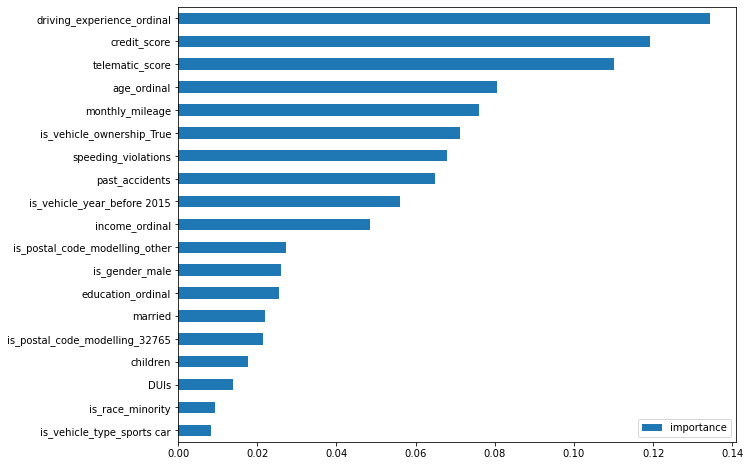

In [72]:
feature_importances = pd.DataFrame(rf_classifier.feature_importances_, 
                                   index=rf_classifier.feature_names_in_, columns=['importance'])
fig, ax = plt.subplots(figsize=(10,8))
feature_importances.sort_values('importance', ascending=True).plot.barh(ax=ax)

The most important features are driving_experience, credit_score, telematic_score, age, monthly_mileage and vehicle_ownership. The least important features are vehicle_type, race, and DUIs. The categorical variables vehicle_type and race each have 2 categories where one of them has very low frequency, as a result they are not very useful for the model. `DUIs` has very low variance. I would convert this feature into categorical with 2 categories: has DUIs and does not have DIUs, train another model and see how it affets model performance.

If I had more time to work on this project, I would follow the next steps:
- tackle imbalanced data in other ways - e.g. oversampling. Check how different ways of dealing with the imbalance affect model performance.
- data leakage - handle missing values using training set and explore smarter ways to deal with missing values
- Investigate the categorical and numerical features more, e.g. investigate more the DUIs - try it as categorical variable

## 2.4 Recommendations

The way the data is collected is not optimal for modelling purposes. Some recommendations for future data collection are:
1. `age` is an important feature. Instead of collecting the age group, my recommendation is to store the actual age of the customer. Grouping it at data collection stage might result in lost information.
2. `driving experience` is an important feature. Instead of collecting the data in groups, my recommendation is to store the actual number of years of driving experience for each customer. Similar to the age data, grouping it at data collection stage might result in lost information.
3. `race` has 2 categories: majority and minority, where 90% of the data points belong to the majority class. As a result it is not a very useful feature. My recommendation is to save the data about race in more categories. 
4. `vehicle_type` has 2 categories: sedan and sports car, where 95% of the data points are sedan. Again this makes it not a very useful feature. Also if the company starts to give insurance for other types of cars (which are not sedan, neither sports car) the current model would not work. My recommendation is to save more detailed information about the type of car and if possible collect data for as many types of cars as possible.
5. Another recommendation is to store the amount of money the customers have claimed in the past year (in case they have made a claim) instead of whether there was a claim made or not. This information can be used to train more accurate models (regression or multi-class classification models) which will help the client to have better and more competitive pricing models.